## Спортивный анализ данных. Платформа Kaggle
### Схемы валидации решения, оптимизация целевых метрик.

### Практическое задание 3.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/Kaggle/Lesson_2/data/'
TRAIN_DATASET_PATH = PATH + 'train.csv'
TEST_DATASET_PATH = PATH + 'test.csv'

#### Загрузка данных

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
print('train.shape', train.shape)
train.head(2)

train.shape (180000, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
print('test.shape', test.shape)
test.head(2)

test.shape (100001, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
TARGET_NAME = 'isFraud'

#### Обзор распределения целевой переменной

In [7]:
train[TARGET_NAME].value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

#### Классификация признаков

In [8]:
INDEPENDENT_VARIABLE_NAMES = train.columns.to_list()[2:]
INDEPENDENT_VARIABLE_NAMES[:3]

['TransactionDT', 'TransactionAmt', 'ProductCD']

In [9]:
NUMERICAL_FEATURE_NAMES = train[INDEPENDENT_VARIABLE_NAMES].select_dtypes(include=[np.number]).columns.to_list()
CATEGORICAL_FEATURE_NAMES = train[INDEPENDENT_VARIABLE_NAMES].select_dtypes(include=[np.object]).columns.to_list()

print(f'count of numerical features {len(NUMERICAL_FEATURE_NAMES)}')
print(f'count of categorical features {len(CATEGORICAL_FEATURE_NAMES)}')

count of numerical features 378
count of categorical features 14


#### Распределение признаков для обучающей и тестовой выборки¶

In [10]:
def plot_train_test_distributions(var_name):
    sns.kdeplot(train[var_name], color="blue", label="train")
    sns.kdeplot(test[var_name], color="green", label="test")
    plt.title(var_name, fontsize=14)
    plt.show()

#### TransactionDT

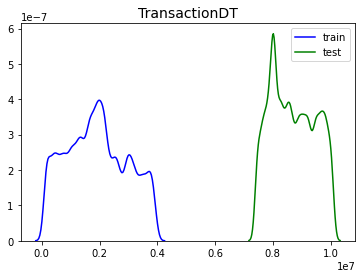

In [11]:
var_name = 'TransactionDT'
plot_train_test_distributions(var_name)

In [12]:
NUMERICAL_FEATURE_NAMES.remove('TransactionDT')

#### Обработка категориальных признаков

In [13]:
class FeatureGenerator:
    def __init__(self, CATEGORICAL_FEATURE_NAMES):
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES
        self.NEW_CATEGORICAL_FEATURE_NAMES = []
        self.LGB_CATEGORICAL_FEATURE_NAMES = []
        self.target_encodings = dict()
        self.ordinal_encoding = dict()
        
        
    def fit(self, train):
        df = train.copy()
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            new_feature = feature + '_'
            lgb_feature = feature + 'lgb'
            self.NEW_CATEGORICAL_FEATURE_NAMES.append(new_feature)
            self.LGB_CATEGORICAL_FEATURE_NAMES.append(lgb_feature)            
            self.target_encodings[feature] = {}
            self.ordinal_encoding[feature] = {}
            for ind, level in enumerate(df[feature].unique()):
                level_value = df.loc[df[feature]==level, TARGET_NAME].mean()
                self.target_encodings[feature][level] = level_value
                self.ordinal_encoding[feature][level] = ind
                
    def transform(self, df):
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            for level in self.target_encodings[feature].keys():
                new_feature = feature + '_'
                lgb_feature = feature + 'lgb'
                df.loc[df[feature] == level, new_feature] = self.target_encodings[feature][level]
                df.loc[df[feature] == level, lgb_feature] = self.ordinal_encoding[feature][level]
                
        df[CATEGORICAL_FEATURE_NAMES] = df[CATEGORICAL_FEATURE_NAMES].astype(str)  
        
        return df

#### Tain_test_split

In [14]:
def train_test_split_ind(df, w=None, k_fold=5):
    ind_0 = list(df.loc[df[TARGET_NAME] == 0, SPLIT_FEATURE_NAME].values)
    ind_1 = list(df.loc[df[TARGET_NAME] == 1, SPLIT_FEATURE_NAME].values)


    test_ind_1 = random.sample(ind_1, len(ind_1) // k_fold)
    train_ind_1 = list(set(ind_1) - set(test_ind_1))

    if w:
        n_test = int(len(test_ind_1) / w)
        n_train = int(len(train_ind_1) / w)

        test_ind_0 = random.sample(ind_0, n_test)
        pool_0 = set(ind_0) - set(test_ind_0)
        train_ind_0 = random.sample(pool_0, n_train)

    else:
        test_ind_0 = random.sample(ind_0, len(ind_0) // k_fold)
        train_ind_0 = list(set(ind_0) - set(test_ind_0))

    train_ind = train_ind_0 + train_ind_1
    test_ind = test_ind_0 + test_ind_1

    random.shuffle(train_ind)
    random.shuffle(test_ind)

    return train_ind, test_ind

In [15]:
def train_valid_split_sets(train_ind, w=None, n_sets=1):
    train_valid_sets = {}
    for i in range(n_sets):    
        train_ind_subset, valid_ind_subset = train_test_split_ind(
            train[train[SPLIT_FEATURE_NAME].isin(train_ind)], w)

        train_valid_sets[i] = (train_ind_subset, valid_ind_subset) 
        
    return train_valid_sets

### Задание 1.
Сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [16]:
SPLIT_FEATURE_NAME = 'TransactionID'

In [17]:
def run_xgb(df_train, df_valid):
    features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
    features.fit(df_train)
    df_train = features.transform(df_train)
    df_valid = features.transform(df_valid)

    SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES

    dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=df_train[TARGET_NAME])
    dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=df_valid[TARGET_NAME])                    

    model_xgb = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          evals=[(dtrain, "train"), (dvalid, "valid")],
                          num_boost_round=1000,
                          early_stopping_rounds=50,  
                          verbose_eval=False,
                          maximize=True)
    
    train_auc = roc_auc_score(df_train[TARGET_NAME], model_xgb.predict(dtrain, ntree_limit=model_xgb.best_iteration))
    valid_auc = roc_auc_score(df_valid[TARGET_NAME], model_xgb.predict(dvalid, ntree_limit=model_xgb.best_iteration))
        
    return  model_xgb, train_auc, valid_auc   

In [18]:
params_xgb = {"booster": "gbtree", 
              "objective": "binary:logistic", 
              "eval_metric": "auc",
              "verbosity": 0,
              "learning_rate": 0.2, 
              "n_estimators": 1000, 
              "reg_lambda": 100, 
              "max_depth": 4, 
              "gamma": 10, 
              "nthread": 6, 
              "seed": 27}

#### Обучение модели

In [19]:
train_ind, test_ind = train_test_split_ind(train)

df_train = train[train[SPLIT_FEATURE_NAME].isin(train_ind)]
df_valid = train[train[SPLIT_FEATURE_NAME].isin(test_ind)]

model_xgb, train_auc, valid_auc = run_xgb(df_train, df_valid)

print(f'ROC-AUC train: {round(train_auc, 4)}, valid: {round(valid_auc, 4)}')

ROC-AUC train: 0.9135, valid: 0.9159


#### Прогноз на Leaderboard

In [20]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(df_train)
df_test = features.transform(test)

SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES
dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES])

n_iter = model_xgb.best_iteration + int(np.sqrt(model_xgb.best_iteration) // 4) + 1
test_auc = roc_auc_score(df_test[TARGET_NAME], model_xgb.predict(dtest, ntree_limit=n_iter))
print(f'ROC-AUC test: {round(test_auc, 4)}')

ROC-AUC test: 0.8702


#### Выводы:
* На валидационной выборке результаты модели немного выше, чем на обучающей, поскольку число деревьев при обучении подбиралось по валидационной выборке.
* Результаты модели на Leaderboard существено ниже, чем на валидации. В какой-то мере это может быть связано с переобучением модели, но большей частью - с неидентичностью распределения признаков на обучающей и тестовой выборке.

### Задание 2
Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [21]:
def run_and_test_xgb(train_indices, valid_indices, test_ind):
    df_train = train[train[SPLIT_FEATURE_NAME].isin(train_indices)]
    df_valid = train[train[SPLIT_FEATURE_NAME].isin(valid_indices)]

    model_xgb, train_auc, valid_auc = run_xgb(df_train, df_valid)

    features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
    features.fit(df_train)

    df_test = train[train[SPLIT_FEATURE_NAME].isin(test_ind)]
    df_test = features.transform(df_test)

    SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES
    dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES])

    n_iter = model_xgb.best_iteration + int(np.sqrt(model_xgb.best_iteration) // 4) + 1
    test_auc = roc_auc_score(df_test[TARGET_NAME], model_xgb.predict(dtest, ntree_limit=n_iter))
    
    return model_xgb, n_iter, train_auc, valid_auc, test_auc

#### Обучение и тестирование модели

In [22]:
train_valid_sets = train_valid_split_sets(train_ind)
train_indices = train_valid_sets[0][0]
valid_indices = train_valid_sets[0][1]

_, _, train_auc, valid_auc, test_auc = run_and_test_xgb(train_indices, valid_indices, test_ind)
print(f'ROC-AUC train: {round(train_auc, 4)}, valid: {round(valid_auc, 4)}, test: {round(test_auc, 4)}')

ROC-AUC train: 0.9105, valid: 0.9017, test: 0.9116


### Задание 3
Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [23]:
def calculate_confidence_interval(scores, conf_interval=0.95):
    left_bound = np.percentile(scores, ((1 - conf_interval) / 2) * 100)
    right_bound = np.percentile(scores, (conf_interval + ((1 - conf_interval) / 2)) * 100)

    return left_bound, right_bound

In [24]:
w = 0.2
n_sets = 30
train_ind, test_ind = train_test_split_ind(train, w)
train_valid_sets = train_valid_split_sets(train_ind, w, n_sets)

In [25]:
auc_list = []
n_iter_list = []
for i in range(n_sets):    
    train_indices = train_valid_sets[i][0]
    valid_indices = train_valid_sets[i][1]
    
    model_xgb, n_iter, train_auc, valid_auc, test_auc = run_and_test_xgb(train_indices, valid_indices, test_ind)
    print(f'{i}. ROC-AUC train: {round(train_auc, 4)}, valid: {round(valid_auc, 4)}, test: {round(test_auc, 4)}')
    
    auc_list.append((train_auc, valid_auc, test_auc))
    n_iter_list.append(n_iter)

0. ROC-AUC train: 0.9048, valid: 0.8991, test: 0.9009
1. ROC-AUC train: 0.9069, valid: 0.8855, test: 0.8982
2. ROC-AUC train: 0.9003, valid: 0.9082, test: 0.9003
3. ROC-AUC train: 0.9079, valid: 0.8904, test: 0.9005
4. ROC-AUC train: 0.9054, valid: 0.9032, test: 0.9021
5. ROC-AUC train: 0.8996, valid: 0.8998, test: 0.8961
6. ROC-AUC train: 0.9056, valid: 0.8986, test: 0.8999
7. ROC-AUC train: 0.9069, valid: 0.8893, test: 0.8989
8. ROC-AUC train: 0.9073, valid: 0.8853, test: 0.9004
9. ROC-AUC train: 0.9038, valid: 0.8882, test: 0.897
10. ROC-AUC train: 0.9044, valid: 0.8963, test: 0.8994
11. ROC-AUC train: 0.9073, valid: 0.8946, test: 0.9012
12. ROC-AUC train: 0.904, valid: 0.8933, test: 0.8983
13. ROC-AUC train: 0.9056, valid: 0.8884, test: 0.8993
14. ROC-AUC train: 0.9054, valid: 0.8856, test: 0.8995
15. ROC-AUC train: 0.9087, valid: 0.8965, test: 0.9026
16. ROC-AUC train: 0.905, valid: 0.9072, test: 0.9023
17. ROC-AUC train: 0.9043, valid: 0.891, test: 0.9005
18. ROC-AUC train: 0.902

In [26]:
np.array(auc_list).mean(axis=0)

array([0.90531178, 0.89463856, 0.89987066])

#### Доверительный интервал

In [27]:
scores = [i[2] for i in auc_list]
calculate_confidence_interval(scores)

(0.896761573320565, 0.9024162813782192)

#### Вывод
* ROC-AUC модели на Leaderboard лежит существенно ниже нижней границы доверительного интервала отложенной выборки. Валидация неудачная. Основная проблема лежит в неидентичности распределения признаков на обучающей выборке и на Leaderboard.

### Задание 4.
Bыполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [28]:
X_adv = pd.concat([train, test], axis=0)
y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))

In [29]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(X_adv)
X_adv = features.transform(X_adv)

SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES

model = xgb.XGBClassifier(n_estimators=50)
model.fit(X_adv[SELECTED_FEATURE_NAMES], y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_pred_adv = model.predict_proba(X_adv[SELECTED_FEATURE_NAMES])
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

1.0


Распределения обучающей выборки и тестовой совершенно разные: roc_auc_score = 1, в идеальном случае roc_auc_score = 0.5.

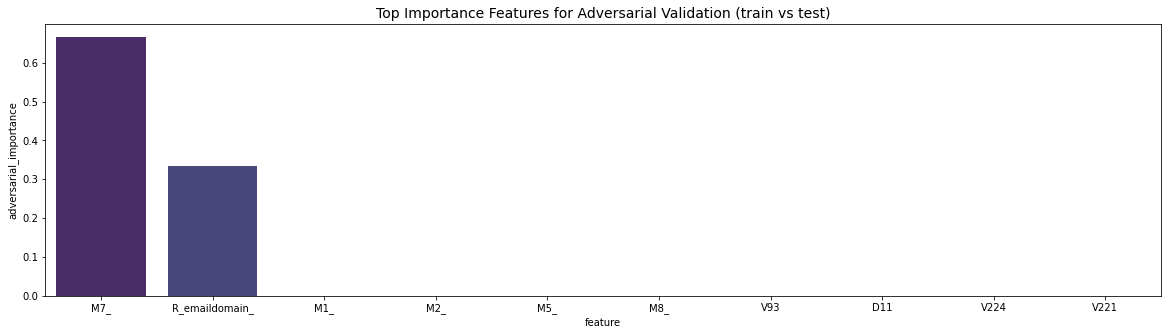

In [31]:
importance = pd.DataFrame({'feature': X_adv[SELECTED_FEATURE_NAMES].columns,
                           'adversarial_importance': model.feature_importances_})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)
plt.show()

In [32]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(train)
train_all = features.transform(train)

In [33]:
y_pred = model.predict_proba(train_all[SELECTED_FEATURE_NAMES])
y_pred

array([[9.9999726e-01, 2.7604669e-06],
       [9.9999589e-01, 4.1250869e-06],
       [9.9999106e-01, 8.9669084e-06],
       ...,
       [9.9999589e-01, 4.1250869e-06],
       [9.9999589e-01, 4.1250869e-06],
       [9.9999726e-01, 2.7604669e-06]], dtype=float32)

In [34]:
pd.cut(y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)).value_counts().sort_index()

(0.0, 0.1]    180000
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

#### Вывод
* Согласно результатам  Adversarial Validation, распределения обучающей выборки и Leaderboard абсолютно разные. Подобрать объекты из обучающей выборки, которые были бы сильно похожи на объекты из assignment_2_test.csv, чтобы использовать их в качестве валидационного набора, не представляется возможным. Сначала имеет смысл попробовать поработать с признаками.

### Задание 5.
Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [35]:
skf = StratifiedKFold(random_state=42, shuffle=True)
df = train[train[SPLIT_FEATURE_NAME].isin(train_ind)]
auc_list = []
for train_index, valid_index in skf.split(df, df[TARGET_NAME]):
    df_train, df_valid = train.loc[train_index, :], train.loc[valid_index, :]    
    model_xgb, train_auc, valid_auc = run_xgb(df_train, df_valid) 
    auc_list.append((train_auc, valid_auc)) 

In [36]:
auc_list

[(0.8781023196713265, 0.8925637680903946),
 (0.8874774926148636, 0.8404647275900576),
 (0.888368586100706, 0.8730476874480033),
 (0.8869083722000293, 0.8581352242725195),
 (0.8824835995576517, 0.8762721997912755)]

#### Доверительный интервал

In [37]:
scores = [i[1] for i in auc_list]
calculate_confidence_interval(scores)

(0.8422317772583039, 0.8909346112604827)

#### Вывод
* Разброс ROC-AUC на валидацонной выборке достаточно большой. Результат на отложенной выборке (задание 3) немного выше верхней границы доверительного интервала на валидацонной выборке. На это мог повлиять фактор случайности при отборе объектов для отложенной выборки. 
* Результат на ЛБ находится внутри доверительного интервала на на валидацонной выборке.

### Задание 6 (опциональное)
Сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [38]:
SPLIT_FEATURE_NAME = 'TransactionDT'

In [39]:
train_ind, test_ind = train_test_split_ind(train)

train_valid_sets = train_valid_split_sets(train_ind)
train_indices = train_valid_sets[0][0]
valid_indices = train_valid_sets[0][1]

_, _, train_auc, valid_auc, test_auc = run_and_test_xgb(train_indices, valid_indices, test_ind)
print(f'ROC-AUC train: {round(train_auc, 4)}, valid: {round(valid_auc, 4)}, test: {round(test_auc, 4)}')

ROC-AUC train: 0.9128, valid: 0.9059, test: 0.902


In [40]:
w = 0.2
n_sets = 30
train_ind, test_ind = train_test_split_ind(train, w)
train_valid_sets = train_valid_split_sets(train_ind, w, n_sets)

In [41]:
auc_list = []
n_iter_list = []
for i in range(n_sets):
    train_indices = train_valid_sets[i][0]
    valid_indices = train_valid_sets[i][1]
    
    model_xgb, n_iter, train_auc, valid_auc, test_auc = run_and_test_xgb(train_indices, valid_indices, test_ind)
    print(f'{i}. ROC-AUC train: {round(train_auc, 4)}, valid: {round(valid_auc, 4)}, test: {round(test_auc, 4)}')
    
    auc_list.append((train_auc, valid_auc, test_auc))
    n_iter_list.append(n_iter)

0. ROC-AUC train: 0.9042, valid: 0.9052, test: 0.8963
1. ROC-AUC train: 0.9079, valid: 0.8956, test: 0.8959
2. ROC-AUC train: 0.9064, valid: 0.8925, test: 0.8943
3. ROC-AUC train: 0.9083, valid: 0.9044, test: 0.8974
4. ROC-AUC train: 0.9071, valid: 0.908, test: 0.8984
5. ROC-AUC train: 0.908, valid: 0.8967, test: 0.8947
6. ROC-AUC train: 0.9092, valid: 0.8946, test: 0.8972
7. ROC-AUC train: 0.9053, valid: 0.8926, test: 0.8934
8. ROC-AUC train: 0.9101, valid: 0.9014, test: 0.8966
9. ROC-AUC train: 0.9078, valid: 0.8967, test: 0.8949
10. ROC-AUC train: 0.9066, valid: 0.8921, test: 0.8951
11. ROC-AUC train: 0.9056, valid: 0.8976, test: 0.8934
12. ROC-AUC train: 0.9058, valid: 0.8901, test: 0.8934
13. ROC-AUC train: 0.9058, valid: 0.9062, test: 0.895
14. ROC-AUC train: 0.9043, valid: 0.8965, test: 0.891
15. ROC-AUC train: 0.9066, valid: 0.8995, test: 0.8949
16. ROC-AUC train: 0.9106, valid: 0.898, test: 0.8979
17. ROC-AUC train: 0.9072, valid: 0.8995, test: 0.8952
18. ROC-AUC train: 0.9051

In [42]:
np.array(auc_list).mean(axis=0)

array([0.90682177, 0.89787605, 0.89504725])

#### Доверительный интервал

In [43]:
scores = [i[2] for i in auc_list]
calculate_confidence_interval(scores)

(0.8925577318648128, 0.8979936012602197)

#### Вывод:
Доверительный интервал результатов на отложенной выборке при Hold-Out валидации по времени (TransactionDT) ближе к результатам на Leaderboard, чем при Hold-Out валидации  по id-транзакции (TransactionID).